<div style='padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Analysis of the 2004 Sumatra-Andaman earthquake</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Part 1: Instrument response and spectral analysis</div>
        </div>
    </div>
</div>

##### Authors:
* Carl Tape ([@carltape](https://github.com/carltape))
* Yongki Andita Aiman
* Tomy Gunawan
* Angel Ling
---

Based on *GEOS 626: Applied Seismology from Carl Tape*

The goals of this problem set are:
1. to practice deconvolving the instrument response from a raw seismogram recorded in “counts”
2. to introduce you to the frequency dependence of the seismic wavefield, especially with regard to seismological investigations of earthquake sources and Earth structure

## Problem 2: Deconvolving the Instrument Response

In [28]:
# Preparation for programming
# Make sure to execute this cell first!
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')                  # do not show warnings
from IPython.display import display, Math, Latex
from time import *
from obspy import *
from obspy.core import read, UTCDateTime
from obspy.clients.fdsn import Client
import numpy as np
import matplotlib.pylab as plt
from obspy.signal.filter import lowpass
from matplotlib.mlab import detrend
from obspy.signal.invsim import cosine_taper 
from mpl_toolkits.basemap import Basemap
from obspy.imaging.beachball import beach
plt.style.use('ggplot')

### Exercise 1

Analyze the raw 10-day time series of the Sumatra earthquake recorded at station CAN (Canberra, Australia), which is shown in Figure 1. We will use the notation c(t) (c is “counts”) to represent the time series.
1. What is the duration of the seismogram?
2. What is the time step?
3. What is the Nyquist frequency?
4. Zoom in on the y-limits with ylim(3e4*[-1 1]) What is the approximate period (in seconds and in days) of the most conspicuous oscillation?
5. Find the largest aftershock in the second half of the record. Use the example code to extract the absolute time, then list the location, magnitude, and origin time of the event from a catalog search in www.globalcmt.org. Hint: the magnitude is Mw > 6.
6. Does this aftershock have the same mechanism as the mainshock?
7. In summary, identify and interpret the main features in the seismogram. Hint: noise is a feature.

In [29]:
# Getting the waveforms
client = Client("IRIS")
t = UTCDateTime("2004-12-26T00:58:53.0")# origin time of the earthquake
starttime = t-(24*3600) # one day before the origin time
endtime = t+(9*24*3600) # 9 days after the origin time
st = client.get_waveforms("G", "CAN", "*", "LHZ", starttime, endtime, attach_response=True)

1. The duration of the seismogram is 863999.0 seconds or 9.999988425925926 days
2. The time step is 1.0 s
3. The Nyquist frequency is 0.5 Hz
4. Zoom-in on the y-axis, showing that the record is dominated by aftershocks (spikes) and a ~12-hour period of tides.


(-30000.0, 30000.0)

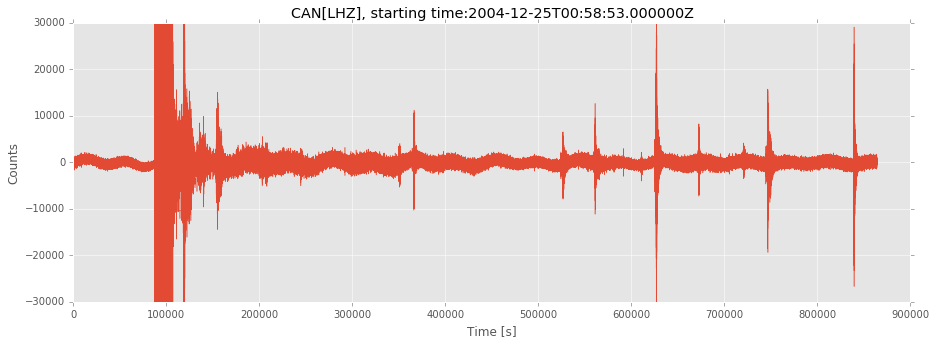

In [31]:
# take a copy of the stream to avoid overwriting the original data
stream = st.copy()
tr = stream[0]
# Choosing the 1st stream, Specify sampling parameters and Nyquist frequency
npts = stream[0].stats.npts           # number of samples
df = stream[0].stats.sampling_rate    # sampling rate
nsec = npts/df                        # sampling time
timestep = 1/df                       # time step
fNy = df / 2.0                        # Nyquist frequency
dur_sec = npts/df                     # Duration of the seismogram in second
dur_day = dur_sec/(24*60*60)          # Duration of the seismogram in day
time = np.linspace(0,nsec,(nsec*df))  # time axis for plotting

print ("1. The duration of the seismogram is", dur_sec, "seconds or", dur_day, "days")
print ("2. The time step is", timestep, "s")
print ("3. The Nyquist frequency is", fNy, "Hz")
print ("4. Zoom-in on the y-axis, showing that the record is dominated by aftershocks (spikes) and a ~12-hour period of tides.")

#plotting parameter
plt.rcParams['figure.figsize'] = 15, 5
plt.rcParams['lines.linewidth'] = 0.5


plt.plot(time,tr.data)
#print (starttime)                  #identify the start time of the seismogram
plt.title('CAN[LHZ], starting time:2004-12-25T00:58:53.000000Z')
plt.xlabel('Time [s]')
plt.ylabel('Counts')
plt.ylim(-3E4,3E4)

5.The largest aftershock occurs around 2005-01-01 06:49:32. GCMT catalog reveals that this is a Mw 6.7 aftershock:

* 200501010625A OFF W COAST OF NORTHERN 
* Date: 2005/ 1/ 1 Centroid Time: 6:25:48.3 GMT
* Lat= 4.97 Lon= 92.22
* Depth= 12.0 Half duration= 5.2
* Centroid time minus hypocenter time: 3.5 
* Moment Tensor: Expo=26 -0.052 -0.669 0.721 -0.287 -0.378 -0.854 
* Mw = 6.7 mb = 6.0 Ms = 6.7 Scalar Moment = 1.2e+26 
* Fault plane: strike=111 dip=68 slip=-173 
* Fault plane: strike=18 dip=84 slip=-22 

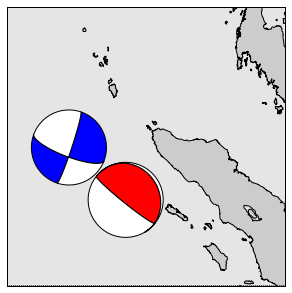

6. This aftershock (blue) is a strike slip fault, which is very different from the thrust mechanism of the mainshock (red). Therefore it is clear that the mainshock triggered earthquakes on other faults. (Alternatively, the mainshock rupture could have included rupture on “minor” strike-slip faults as well.)


In [32]:
#Plotting the focal mechanism of mainshock and aftershock of Sumatra Earthquake
# create Basemap instance with Miller projection
m = Basemap( projection='mill',llcrnrlat=0,urcrnrlat=10,
            llcrnrlon=90,urcrnrlon=100,resolution='h')

m.drawcoastlines()
m.fillcontinents()
m.drawparallels(np.arange(-90., 120., 30.))
m.drawmeridians(np.arange(0., 420., 60.))
m.drawmapboundary()

# Add beachballs for main shock and some aftershock
lats = [ 3.09, 4.97 ]
lons = [ 94.26, 92.22]
x, y = m(lons, lats)
# Some focal mechanisms for beachball routine, specified as [strike, dip, rake], source : www.globalcmt.org
focmecs = [[329, 8, 110], [111, 68, -173]]
colour = ['r','b']
ax = plt.gca()
for i in range(len(focmecs)):
    b = beach(focmecs[i], xy=(x[i], y[i]), width=300000, linewidth=1, facecolor=colour[i])
    b.set_zorder(10)
    ax.add_collection(b)

plt.show()
print ("6. This aftershock (blue) is a strike slip fault, which is very different from the thrust mechanism of the mainshock (red). Therefore it is clear that the mainshock triggered earthquakes on other faults. (Alternatively, the mainshock rupture could have included rupture on “minor” strike-slip faults as well.)")

7.The main features in the 10-day seismogram at Canberra are:
* pre-Sumatra noise
* the Sumatra earthquake
* aftershocks
* a 12-hour (tidal) oscillation (only seen after zooming in; see Exercise 1 number 4)

### Exercise 2
1. Plot the full amplitude spectrum, use axis tight to see the full limits.
2. Plot using log-log scaling (loglog). Label the frequency window [0.2, 1.0] mHz (note mHz, not Hz).
3. Interpret the largest-amplitude spikes in the spectrum.
4. What is the maximum allowable frequency and why?
5. What is the minimum (non-zero) allowable frequency and why? What is the corresponding period?

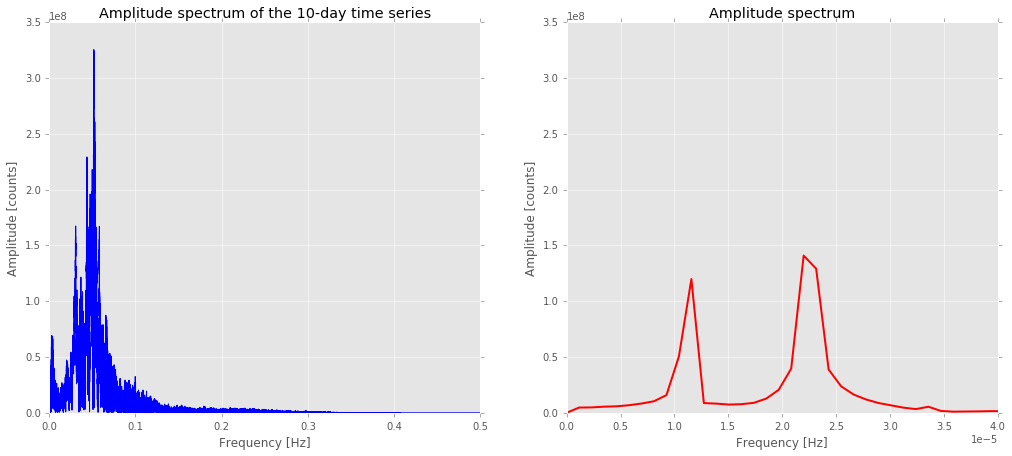

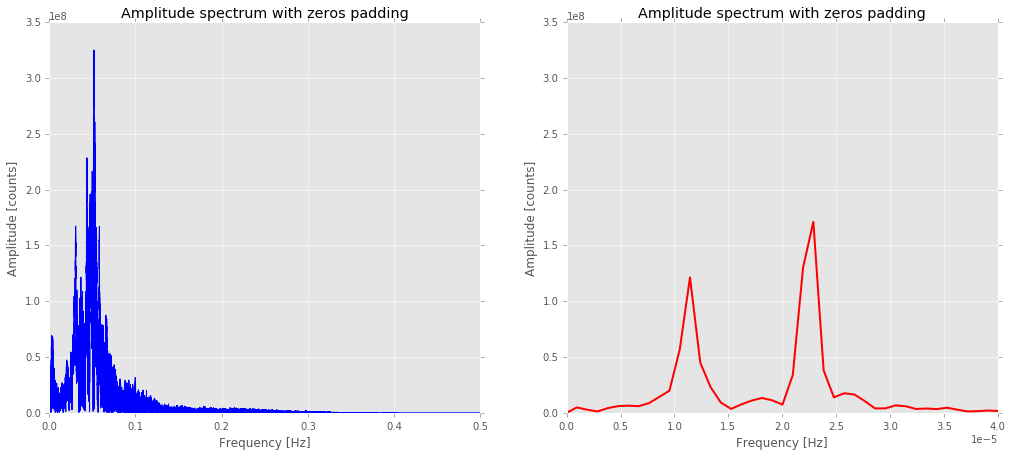

1. Figure above shows the amplitude spectrum of the 10-day time series from Canberra, including the main arrival.
   The large peak(s) near f = 0 are the tides, with periods of approximately 12 hours and 24 hours.


In [33]:
# take a copy of the stream to avoid overwriting the original data
can = st.copy()
y  = can[0].data                         

# Taper
taper_percentage = 0.1                          # Percentage of tapering applied to signal
taper = cosine_taper(npts,taper_percentage)     # Define cosine taper to be used
y_taper = y * taper                             # Taper signal

# Detrend Signal
y_detrend = detrend(y_taper, 'linear')

# Frequency Domain
y_fnew = np.fft.rfft(y_detrend) 

# zeros padding
y_pad = np.lib.pad(y_detrend, (92289,92289),'constant',constant_values=(0,0))
y_fpad= np.fft.rfft(y_pad)

#plotting parameter
plt.rcParams['figure.figsize'] = 17, 7
plt.rcParams['lines.linewidth'] = 2


# Plot the full spectrum of the signal
plt.subplot(121)
freq = np.linspace(0, fNy, len(y_fnew))         # Frequency axis for plotting
plt.plot(freq, abs(y_fnew), 'b', lw=1) 
plt.title('Amplitude spectrum of the 10-day time series')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [counts]')


# Plot the spectrum of the signal that zoomed-in on the low frequency
plt.subplot(122)
plt.plot(freq, abs(y_fnew), 'r', lw=2) 
plt.title('Amplitude spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [counts]')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlim(0, 4E-5) # limited to lower frquencies
plt.show()

#Plot the full spectrum of the signal with zeros padding
plt.subplot(121)
freq1 = np.linspace(0, fNy, len(y_fpad))         # Frequency axis for plotting
plt.plot(freq1, abs(y_fpad), 'b', lw=1) 
plt.title('Amplitude spectrum with zeros padding')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [counts]')


# Plot the spectrum of the signal with zeros padding that zoomed-in on the low frequency
plt.subplot(122)
plt.plot(freq1, abs(y_fpad), 'r', lw=2) 
plt.title('Amplitude spectrum with zeros padding')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [counts]')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlim(0, 4E-5) # limited to lower frquencies
plt.show()

print ("1. Figure above shows the amplitude spectrum of the 10-day time series from Canberra, including the main arrival.")
print ("   The large peak(s) near f = 0 are the tides, with periods of approximately 12 hours and 24 hours.")

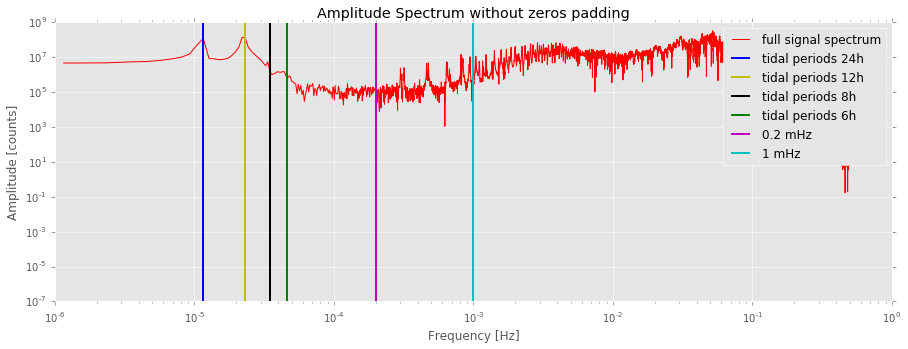

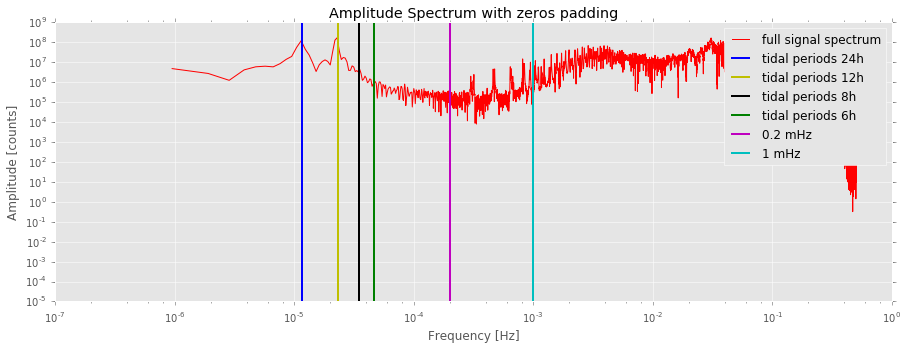

In [36]:
# Set up frequency windows
f0 = 1/(24*3600)
k = [f0, 2*f0, 3*f0, 4*f0, 2E-4, 1E-3]
color = ['b','y','k','g','m','c']
label = ['tidal periods 24h','tidal periods 12h','tidal periods 8h','tidal periods 6h','0.2 mHz','1 mHz']

#plotting parameter
plt.rcParams['figure.figsize'] = 15, 5
plt.rcParams['lines.linewidth'] = 0.5


# Plot frequency domain in log-log scale
plt.loglog(freq, abs(y_fnew), 'r', label="full signal spectrum", lw=1) 
for i in range(len(k)):
    b = plt.axvline(k[i], color=color[i], label=label[i], lw=2)
plt.legend()
plt.title('Amplitude Spectrum without zeros padding')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [counts]')
plt.show()

# Plot frequency domain in log-log scale
plt.loglog(freq1, abs(y_fpad), 'r', label="full signal spectrum", lw=1) 
for i in range(len(k)):
    c = plt.axvline(k[i], color=color[i], label=label[i], lw=2)
plt.legend()
plt.title('Amplitude Spectrum with zeros padding')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [counts]')
plt.show()

2.Amplitude spectrum of the 10-day time series from Canberra, including the main arrival. The first four spikes are for kf0,where f0 = 1/(24 * 3600) = 1.1574 × 10−5 Hz is the diurnal (24-hour) period and k = 1, 2, 3, 4. The first two peaks are the expected tidal periods of 24 and 12 hours. It is unclear (to me) what the third and fourth peaks are (periods 8 and 6 hours), but presumably they are tidal harmonics (e.g., see Appendix A). The frequency range of [1, 2] mHz is also shown (between rightmost vertical lines); the mode peaks are visible in this range.

3.The maximum peaks are associated with tides (24-hour and 12-hour periods.

4.The maximum frequency is the Nyqust frequency (0.5 Hz).

$f_Nyq = \frac{1}{2 delta (t)}=$ 0.5 Hz, where $delta (t)= $1s is time sampling. 

5.The minimum non-zero frequency is determined from the length of the time series and also the sample rate.

For signal **without zeros padding** in computing the Fourier transform, then we would have

$f_min = \frac{1}{n×delta(t)} = \frac{1}{863999 × 1} = 1.16 × {10^−}^6 Hz$

This corresponds to a period of 9.99 days

For signal **with zeros padding** in computing the Fourier transform, then we would have

$f_min = \frac{1}{n×delta(t)} = \frac{1}{1048577 × 1} = 9.54× {10^-}^7  Hz$

This corresponds to a period of 12.1 days


### Exercise 3

1. Plot the amplitude spectrum (do not use any log scaling) over the frequency window [0.2, 1.0] mHz.
2. Label each of the peaks that you see (e.g., Park et al., 2005).
3. Why are some of the peaks “split” but one is not?
4. What is the significance of some of the smallest peaks that you identified?


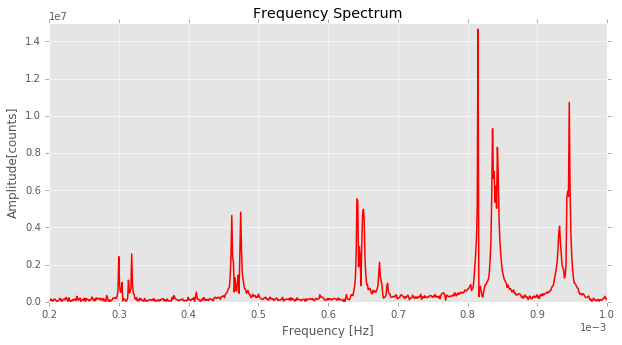

In [37]:
#plotting parameter
plt.rcParams['figure.figsize'] = 10, 5
plt.rcParams['lines.linewidth'] = 0.5

# Plot Frequency spectrum in [0.2, 1] mHz window
plt.plot(freq, abs(y_fnew), 'r', lw=1.5) 
plt.legend()
plt.title('Frequency Spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude[counts]')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlim(2E-4, 1E-3) # limited to frequency window
plt.ylim(0.0, 1.5E7) # Zoom in 
plt.show()

1. Figure above shows a zoom in of amplitude spectral of raw data without loglog scaling.
2. The peaks can be identified in Figure 1 of Park et al. (2005). The similarity of the y-axis values suggests that Park is also plotting the amplitude spectrum of the raw time series (in counts). However, they do not list any units or label associated with the y axis.

<img src="images/Park et al_2005.png" style="width: 400px; float: left;"/>

**Park et al. (2005)**



3.From Park et al. (2005): “For a spherical reference model, all $2l+1$ vibrations of $_nS_{lm}$ or $_nT_{lm}$ have identical frequency. On the real Earth, departures from the symmetries of a spherical reference model cause its free oscillations to couple, hybridize, and suffer fine-scale splitting of their vibrational frequencies. Frequency splitting of free oscillations with periods T > 1000 s is caused mainly by Earth’s rotation, similar to Zeeman splitting of electron energies in an external magnetic field.” The $_0S_0$ peak at 0.815 mHz (period 20.5 minutes) is the “breathing mode” and is not subject to splitting, since $l = 0:$ since ${−l}\leq{ m} \leq{l}$, we must have $m = 0$ only. Other peaks are split due to deviations of from the Spherical Non-Rotating Elastic Isotropic (SNREI) model. For the gravest modes, the frequency deviation of the mth singlet from the $m = 0$ degenerate frequency can be computed as (Dahlen and Tromp, 1998,Eq. 14.54)


<img src="images/equation1.png" style="width: 400px; float: left;"/>

where expressions for a and c are primarily associated with ellipticity (but also large-7 scale structure), and b is associated with rotation.


4.Regarding some of the smallest peaks visible, some of these are toroidal oscillations but observed on this vertical component! From Park et al. (2005): “The coupling between spheroidal and toroidal modes associated with Earth’s Coriolis force causes them to form hybrid vibrational patterns. The hybridized toroidal modes are predicted to acquire a vertical vibrational component, a feature nominally restricted to spheroidal modes.”

### Exercise 4

Using the same frequencies that you used to define the full spectrum, evaluate the instrument response to acceleration and plot it as an amplitude spectrum over the full range of frequencies!

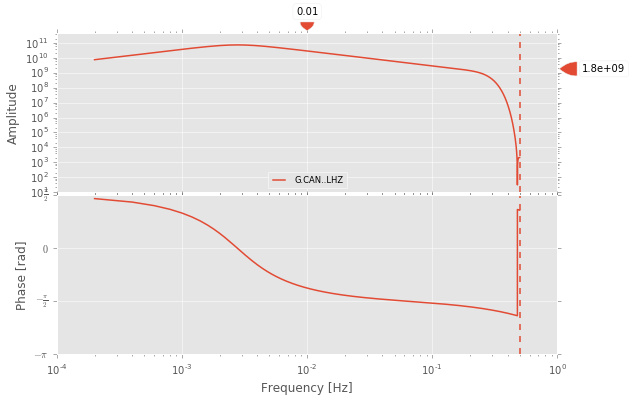

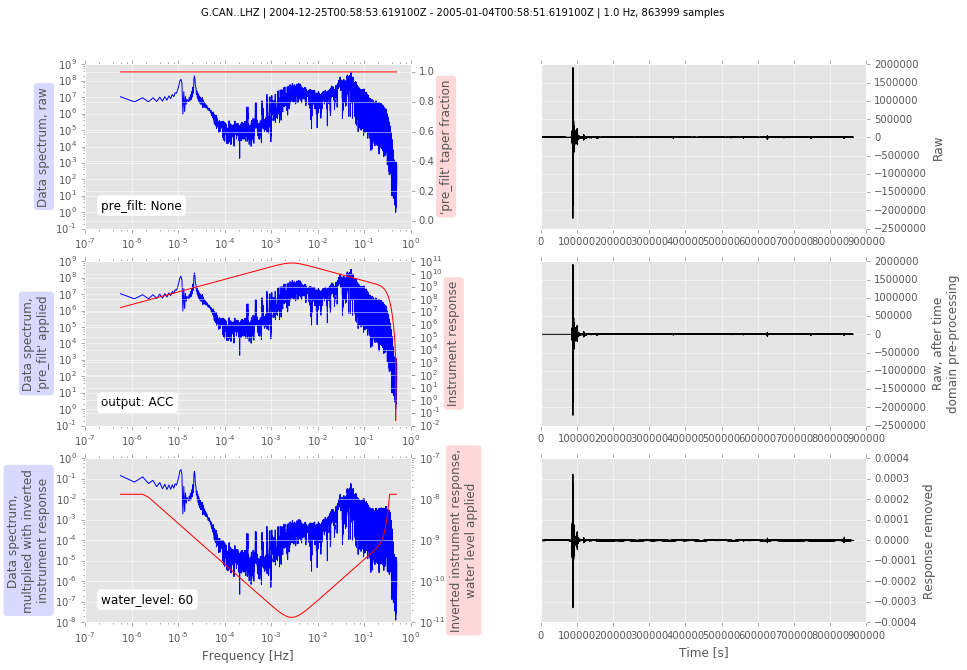

In [11]:
# Plot station response
inv = client.get_stations(network="G", station="CAN", channel="LHZ", level="response", 
                     starttime=starttime, endtime=endtime)

inv.plot_response(min_freq=2E-4, output='ACC')

tr_new = st.select(component="Z").copy().remove_response(inventory=inv, output="ACC", plot=True)[0]

### Exercise 5

The raw seismogram is a convolution of the ground acceleration with the instrument response. Written in the time domain and frequency domain, this is:

<img src="images/equation2.png" style="width: 300px; float: left;"/>


1. Deconvolve (or “remove”) the instrument response from the raw spectral seismogram to obtain the spectral acceleration and plot it!
2. Plot the spectral acceleration over the frequency range [0.2, 1.0] mHz (no log scaling), and compare it with raw spectral seismogram. What is the effect of the deconvolution on the relative amplitudes of the peaks?

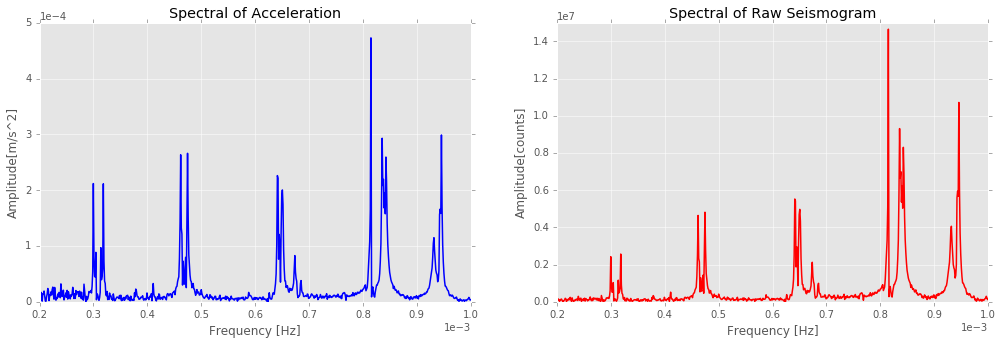

In [42]:
# Deconvolution
# Remember to copy the waveform!

tr_de = st.select(component="Z").copy().remove_response(inventory=inv, output="ACC")[0].taper(0.05)

D = np.fft.rfft(tr_de.data)
freqs = np.fft.rfftfreq(tr_de.stats.npts, d=tr_de.stats.delta)

#plotting parameter
plt.rcParams['figure.figsize'] = 17, 5
plt.rcParams['lines.linewidth'] = 0.5

# spectral of acceleration
plt.subplot(121)
plt.plot(freqs, np.abs(D),'b', lw=1.5)
plt.xlim(0.2E-3, 1.0E-3)
plt.ylim(0.0, 5.0E-4)
plt.title('Spectral of Acceleration')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude[m/s^2]')
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))


# spectral of raw seismogram
plt.subplot(122)
plt.plot(freq, abs(y_fnew), 'r', lw=1.5) 
plt.xlim(0.2E-3, 1.0E-3)
plt.ylim(0.0, 1.5E7)
plt.title('Spectral of Raw Seismogram')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude[counts]')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()



Figures above show the comparison over the frequency range 0.2-1.0 mHz. The amplitude spectrum, after deconvolution, of the lowest-frequency modes are increased relative to the amplitude of the higher-frequency modes. This is a direct consequence
of the linear instrument response over this frequency range. This same spectrum is shown in Park et al. (2005, Figure 1)

### Exercise 6

Does your spectrum of acceleration look different from the one in Park et al. (2005)? Why might this be the case? In other words, what “choices” were taken that could influence some of the details in the spectrum?

<img src="images/Park et al_2005.png" style="width: 400px; float: left;"/>

**Park et al. (2005)**

Our spectrum does not look exactly like the one in Figure 1 in Park et al. (2005). Here are some differences:
1. The units on the y axis. There are no units lited in the published figure, so it is hard to say whether the instrument response has been deconvolved. The units are suggestive of counts, though the match is not exact with ours either.
2. The relative amplitudes of the peaks are different. Our 0S0 peak is by far the largest peak, but this is not the case in the published version.
3. The smallest peaks, such as 0T2 and 2S1, are more prominent in the published version. If we zoom in on either the amplitude spectrum, or the squared-amplitude spectrum, then we can see that these peaks are indeed present (Figure S6).

Here are some factors that influences the details of a spectrum:
1. Whether the instrument response was removed. As we saw in exercise 5, this can change the relative (and absolute) amplitudes of the peaks.
2. The duration of the time window. Both are 10 days (240 hours).
3. The start time of the time window. Ours is from before the event. They do not state when theirs is. For other stations it makes a big difference whether the direct arrival is included. 
4. The sampling rate of the time series. Ours is 1 sps; theirs is not stated.
5. The taper applied. Ours is a Hanning window; theirs is not stated.
6. The station location code. For some stations there are multiple location codes, so it’s hard to know which seismogram was used. For example, a deep borehole recorded might be different from a surface recording.
7. Corrections for changes in atmospheric pressure (Z¨urn and Widmer , 1995). In Note 47, Park et al. (2005) states that they do not need to perform an atmospheric correction because the signal-to-noise is high enough.

### References

* Ammon, C. J., et al. (2005), Rupture process of the 2004 Sumatra-Andaman earthquake, *Science, 308*, 1133–1139.
* Dahlen, F. A., and J. Tromp (1998), *Theoretical Global Seismology*, Princeton U. Press, Princeton, New Jersey, USA.
* Lay, T., et al. (2005), The great Sumatra-Andaman earthquake of 26 December 2004, *Science, 308*, 1127–1133.
* Ni, S., D. Helmberger, and H. Kanamori (2005), Energy radiation from the Sumatra earthquake, *Nature*, 434, 582.
* Park, J., et al. (2005), Earth’s free oscillations excited by the 26 December 2004 Sumatra Andaman earthquake, *Science, 308*, 1139–1144.
* Shearer, P. M. (2009), *Introduction to Seismology*, 2 ed., Cambridge U. Press, Cambridge, UK.
* Stein, S., and M. Wysession (2003), *An Introduction to Seismology, Earthquakes, and Earth Structure*, Blackwell, Malden, Mass., USA.